In [67]:
import os
import pickle
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
output_dir = 'output_samples'
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from copy import deepcopy
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import precision_recall_fscore_support

In [68]:
def load_samples(output_dir='output_samples'):
    '''
       Parameters:
            output_dir (str): Ścieżka do katalogu, gdzie zapisane są próbki, domyślnie 'output_samples'.

        Returns:
            samples (list): Lista próbek, gdzie każda próbka jest krotką zawierającą:
                - img (Tensor): obraz w formie tensora PyTorch.
                - label_1 (list): lista etykiet 
                - label_2 (list): lista etykiet 
                - spatial_relation (str): relacja przestrzenna pomiędzy elementami na obrazie

        Każdy podkatalog w output_dir reprezentuje jedną próbkę i musi zawierać:
            - image.png (opcjonalne): obraz w formacie PNG (służy tylko do weryfikacji).
            - data.pkl: zawiera etykiety i relacje (label_1, label_2, spatial_relation).
            - tensor.pth: zawiera obraz w formacie tensora

        Funkcja przechodzi przez każdy katalog próbki, ładuje tensor obrazu oraz deserializuje dane z pliku pickle do odpowiednich zmiennych, a następnie dodaje je do listy próbek, którą zwraca.
        '''
    
    samples = []

    for i in range(1, len(os.listdir(output_dir)) + 1):
        sample_dir = os.path.join(output_dir, f'sample_{i}')
        
        # img_path = os.path.join(sample_dir, 'image.png')
        data_path = os.path.join(sample_dir, 'data.pkl')
        tensor_path = os.path.join(sample_dir, 'tensor.pth')

        # ładowanie obrazu - zakomentowane, bo jest tylko do przejrzenia jakie mnije więcej obrazy mamy
        # img = Image.open(img_path)
        img = torch.load(tensor_path)


        with open(data_path, 'rb') as file:
            data = pickle.load(file)
            label_1 = data['label_1']
            label_2 = data['label_2']
            spatial_relation = data['spatial_relation']

        samples.append((img, label_1, label_2, spatial_relation))

    return samples

Label 1: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], Label 2: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1], Spatial Relation: below left


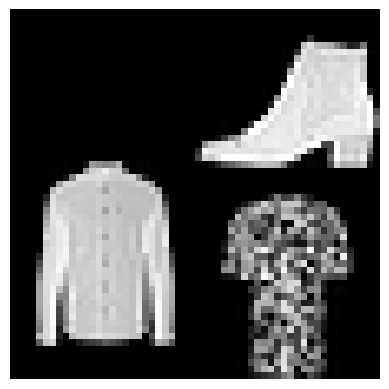

Label 1: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], Label 2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], Spatial Relation: below right


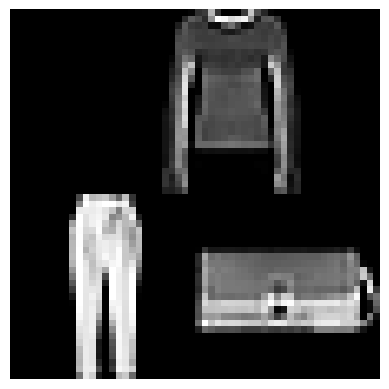

Label 1: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], Label 2: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0], Spatial Relation: left


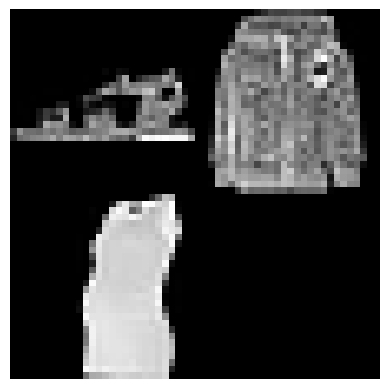

Label 1: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0], Label 2: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0], Spatial Relation: below left


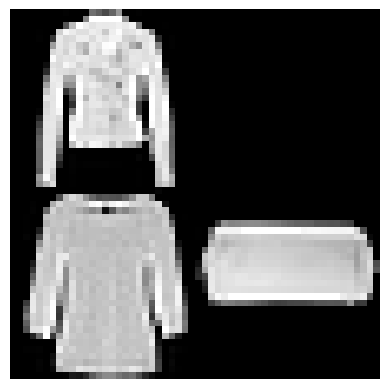

Label 1: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], Label 2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], Spatial Relation: above left


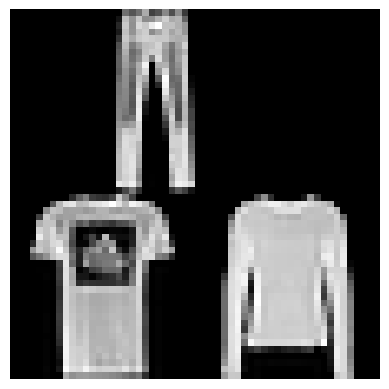

In [69]:
loaded_samples = load_samples(output_dir)
for img, label_1, label_2, spatial_relation in loaded_samples[:2]:
    print(f'Label 1: {label_1}, Label 2: {label_2}, Spatial Relation: {spatial_relation}')
    plt.imshow(img.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.show()

model 2 for identifying relations between 2 objects with three present objects in an image

In [70]:
class ThreeObjectCNN(nn.Module):
    def __init__(self):
        super(ThreeObjectCNN, self).__init__()
        # Krok 1: warstwa konwolucyjna 3x3 z 32 cechami wyjściowymi
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # Krok 1: normalizacja dla 1 warstwy konwolucyjnej
        self.batch_norm1 = nn.BatchNorm2d(32)
        # Krok 1: warstwa Max Pooling z oknem 2x2
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Krok 2: warstwa konwolucyjna 3x3 z 64 cechami wyjściowymi 
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Krok 2: normalizacja dla 2 warstwy konwolucyjnej
        self.batch_norm2 = nn.BatchNorm2d(64)
        # Krok 2: pooling użyjemy ten sam co w kroku 1

        # Krok 3: warstwy fully connected
        self.fc_label1 = nn.Linear(10, 64)
        self.fc_label2 = nn.Linear(10, 64)

        # Krok 5: warstwa fully connected
        '''
        Jeśli rozmiar wejściowego obrazu to 56x56, 
        a każda operacja pooling zmniejsza wymiary o połowę, 
        to po dwóch takich operacjach otrzymamy mapę cech 
        o rozmiarze 14x14 (56 -> 28 po pierwszym pooling, a następnie 28 -> 14 po drugim pooling).
        Warstwa konwolucyjna (self.conv2) produkuje 64 cechy wyjściowe,
        więc po spłaszczeniu otrzymujemy tensor o rozmiarze 64 * 14 * 14
        Dodatkowo, dodajemy 2 * 64 cech odpowiadających dwóm wektorom z etykiet obiektów, stąd + 64 + 64 w obliczeniach
        Zatem w pełni połączona warstwa (self.fc1) przyjmuje 12672 cech wejściowych 
        i zmniejsza ich wymiar do 512 cech wyjściowych.
        '''
        # 12672 = 64 * 14 * 14 + 64 + 64
        self.fc1 = nn.Linear(64 * 14 * 14 + 64 + 64, 512)  
        # Krok 6: warstwa fully connected
        self.fc2 = nn.Linear(512, 8) 
        
        'The dropout rate was 0.3'
        self.dropout = nn.Dropout(0.3)

    def forward(self, x, label_1, label_2):
        # Krok 1
        x = self.pool(F.relu(self.batch_norm1(self.conv1(x))))
        # Krok 2
        x = self.pool(F.relu(self.batch_norm2(self.conv2(x))))
        
        # Spłaszczenie wyjścia warstw konwolucyjnych
        x = x.view(x.size(0), -1)

        label_1 = label_1.float()
        label_2 = label_2.float()
        label_1 = F.relu(self.fc_label1(label_1))
        label_2 = F.relu(self.fc_label2(label_2))
        
        # Krok 4: konkatenacja
        x = torch.cat((x, label_1, label_2), 1)
        
        # Krok 5: warstwa fully connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # Krok 6: warstwa fully connected
        x = self.fc2(x)
        
        # Krok 6: softmax
        x = F.log_softmax(x, dim=1)
        
        return x


miscellaneous

In [ ]:
# dictionary that maps spatial relations to indices
spatial_relation_to_index = {
            'above': 0, 'below': 1, 'left': 2, 'right': 3,
            'below left': 4, 'below right': 5, 'above left': 6, 'above right': 7
        }
batch_size = 64

loaded_samples = load_samples(output_dir)

# transformations for mini batch
images = torch.stack([item[0] for item in loaded_samples])
labels_1 = torch.tensor([item[1] for item in loaded_samples])
labels_2 = torch.tensor([item[2] for item in loaded_samples])
spatial_relations = [item[3] for item in loaded_samples]
target_indices = torch.tensor([spatial_relation_to_index[rel] for rel in spatial_relations])
dataset = TensorDataset(images, labels_1.float(), labels_2.float(), target_indices)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# ustawienia dla early stopping
val_output_dir='val_samples'
val_samples = load_samples(val_output_dir)
early_stopping_patience = 20  
min_delta = 0.001  
best_loss = float('inf')
epochs_no_improve = 0
best_model = None

#### trenowanie modelu

In [78]:
model = ThreeObjectCNN()

'Adam was used for the optimiser. Categorical cross entropy was used for the cost function'
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

'and rate decay was used to decrease it further after each epoch'
scheduler = ExponentialLR(optimizer, gamma=0.95) 

model.train()

num_epochs = 1000 
for epoch in range(num_epochs):
    total_loss = 0

    for img_batch, label_1_batch, label_2_batch, target_batch in data_loader:
        # każdy batch powinien mieć niezależny wpływ na aktualizację parametrów
        optimizer.zero_grad()

        # Forward pass
        outputs = model(img_batch, label_1_batch, label_2_batch)
        loss = criterion(outputs, target_batch)
       
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * img_batch.size(0)

    scheduler.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(loaded_samples):.4f}')

    # early stopping
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for img, label_1, label_2, spatial_relation in val_samples:
            outputs = model(img.unsqueeze(0), torch.tensor([label_1], dtype=torch.float), torch.tensor([label_2], dtype=torch.float))
            target_index = spatial_relation_to_index[spatial_relation]
            loss = criterion(outputs, torch.tensor([target_index]))
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_samples)
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')

    if avg_val_loss < best_loss - min_delta:
        best_loss = avg_val_loss
        epochs_no_improve = 0
        best_model = deepcopy(model.state_dict())
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print('Early stopping')
            break
    print(f'epochs with no improvement: {epochs_no_improve}')

if best_model is not None:
    model.load_state_dict(best_model)

Epoch [1/1000], Loss: 5.1906
Epoch [1/1000], Validation Loss: 2.0411
epochs with no improvement: 0
Epoch [2/1000], Loss: 2.0284
Epoch [2/1000], Validation Loss: 1.9821
epochs with no improvement: 0
Epoch [3/1000], Loss: 1.9429
Epoch [3/1000], Validation Loss: 1.9545
epochs with no improvement: 0
Epoch [4/1000], Loss: 1.8963
Epoch [4/1000], Validation Loss: 1.9297
epochs with no improvement: 0
Epoch [5/1000], Loss: 1.8514
Epoch [5/1000], Validation Loss: 1.9423
epochs with no improvement: 1
Epoch [6/1000], Loss: 1.8169
Epoch [6/1000], Validation Loss: 1.9255
epochs with no improvement: 0
Epoch [7/1000], Loss: 1.7755
Epoch [7/1000], Validation Loss: 1.9230
epochs with no improvement: 0
Epoch [8/1000], Loss: 1.7249
Epoch [8/1000], Validation Loss: 1.9851
epochs with no improvement: 1
Epoch [9/1000], Loss: 1.6821
Epoch [9/1000], Validation Loss: 2.0052
epochs with no improvement: 2
Epoch [10/1000], Loss: 1.6345
Epoch [10/1000], Validation Loss: 1.9872
epochs with no improvement: 3
Epoch [1

#### f-score


In [80]:
def calculate_f1(model, test_samples):
    y_true = []
    y_pred = []

    model.eval()  

    with torch.no_grad():  
        for img, label_1, label_2, spatial_relation in test_samples:
            outputs = model(img.unsqueeze(0), torch.tensor([label_1]), torch.tensor([label_2]))
            _, predicted = torch.max(outputs.data, 1)

            target_index = spatial_relation_to_index[spatial_relation]
            y_true.append(target_index)
            y_pred.append(predicted.item())

    precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    return precision, recall, f1_score

#### wyniki na danych testowych

In [79]:
test_dir = 'test_samples'
test_samples = load_samples(test_dir)

In [81]:
precision, recall, f1_score = calculate_f1(model, test_samples)
print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}')

Precision: 0.17843045112781955, Recall: 0.17, F1 Score: 0.1493324000507463
